<h2>Problem Definition</h2>

<h2>Solution Specification</h2>

<h2>Data Cleaning and Preprocessing</h2>

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_json('image-data.json')
df.head()

,artists,comments,faves,image_paths,image_urls
0,get-sherlock,22,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
1,WuLiao-Yuzi,69,"2,110",[full/ba47403c06820d230acd79405fb8f1cf1e58c6fe...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
2,Moniqua1213,11,218,[full/b6465a0251d8d7381d2e108b3d8ec1e4767cb727...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
3,Gigei,66,883,[full/a212ffab3456626f176885fe1d5dcb5fc9fa0f0c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
4,403shiomi,48,490,[full/6c05caa5b126250613307f70e506f07f1e2513c3...,[https://images-wixmp-ed30a86b8c4ca887773594c2...


In [3]:
#convert faves and comments to int
df['faves'] = df['faves'].str.replace(',', '').astype(int)
df['comments'] = df['comments'].str.replace(',', '').astype(int)

In [89]:
#look at top 15 artists sorted by total number of favorites and comments
#number of images within the database
artist_post_count = df.groupby('artists').agg({'faves':sum,
                           'comments': 'sum',
                           'image_urls':'count',
                          }).sort_values(by=['faves','comments','image_urls'],
                                         ascending=False).reset_index()
artist_post_count.rename(columns={'image_urls': 'no_of_posts'}, inplace=True)
artist_post_count.head(5)


,artists,faves,comments,no_of_posts
0,maXKennedy,43670,4901,54
1,dauntingfire,42467,3865,22
2,AmandaTolleson,38604,3944,11
3,mlcamaro,29561,1050,14
4,alicexz,23482,1144,3


In [90]:
#predicting popularity based on the artist's number of posts
new_df = pd.merge(df, artist_post_count.loc[:,['artists','no_of_posts']],
                  how='left', on='artists')
new_df.head()


,artists,comments,faves,image_paths,image_urls,no_of_posts
0,get-sherlock,22,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,5
1,WuLiao-Yuzi,69,2110,[full/ba47403c06820d230acd79405fb8f1cf1e58c6fe...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,2
2,Moniqua1213,11,218,[full/b6465a0251d8d7381d2e108b3d8ec1e4767cb727...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,2
3,Gigei,66,883,[full/a212ffab3456626f176885fe1d5dcb5fc9fa0f0c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,1
4,403shiomi,48,490,[full/6c05caa5b126250613307f70e506f07f1e2513c3...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,23


<h2>Data Analysis</h2>

(array([ 21.,  66., 260., 456., 410., 279., 165.,  76.,  34.,   4.]),
 array([2.56494936, 3.2562619 , 3.94757445, 4.63888699, 5.33019954,
        6.02151208, 6.71282463, 7.40413717, 8.09544972, 8.78676226,
        9.47807481]),
 <a list of 10 Patch objects>)

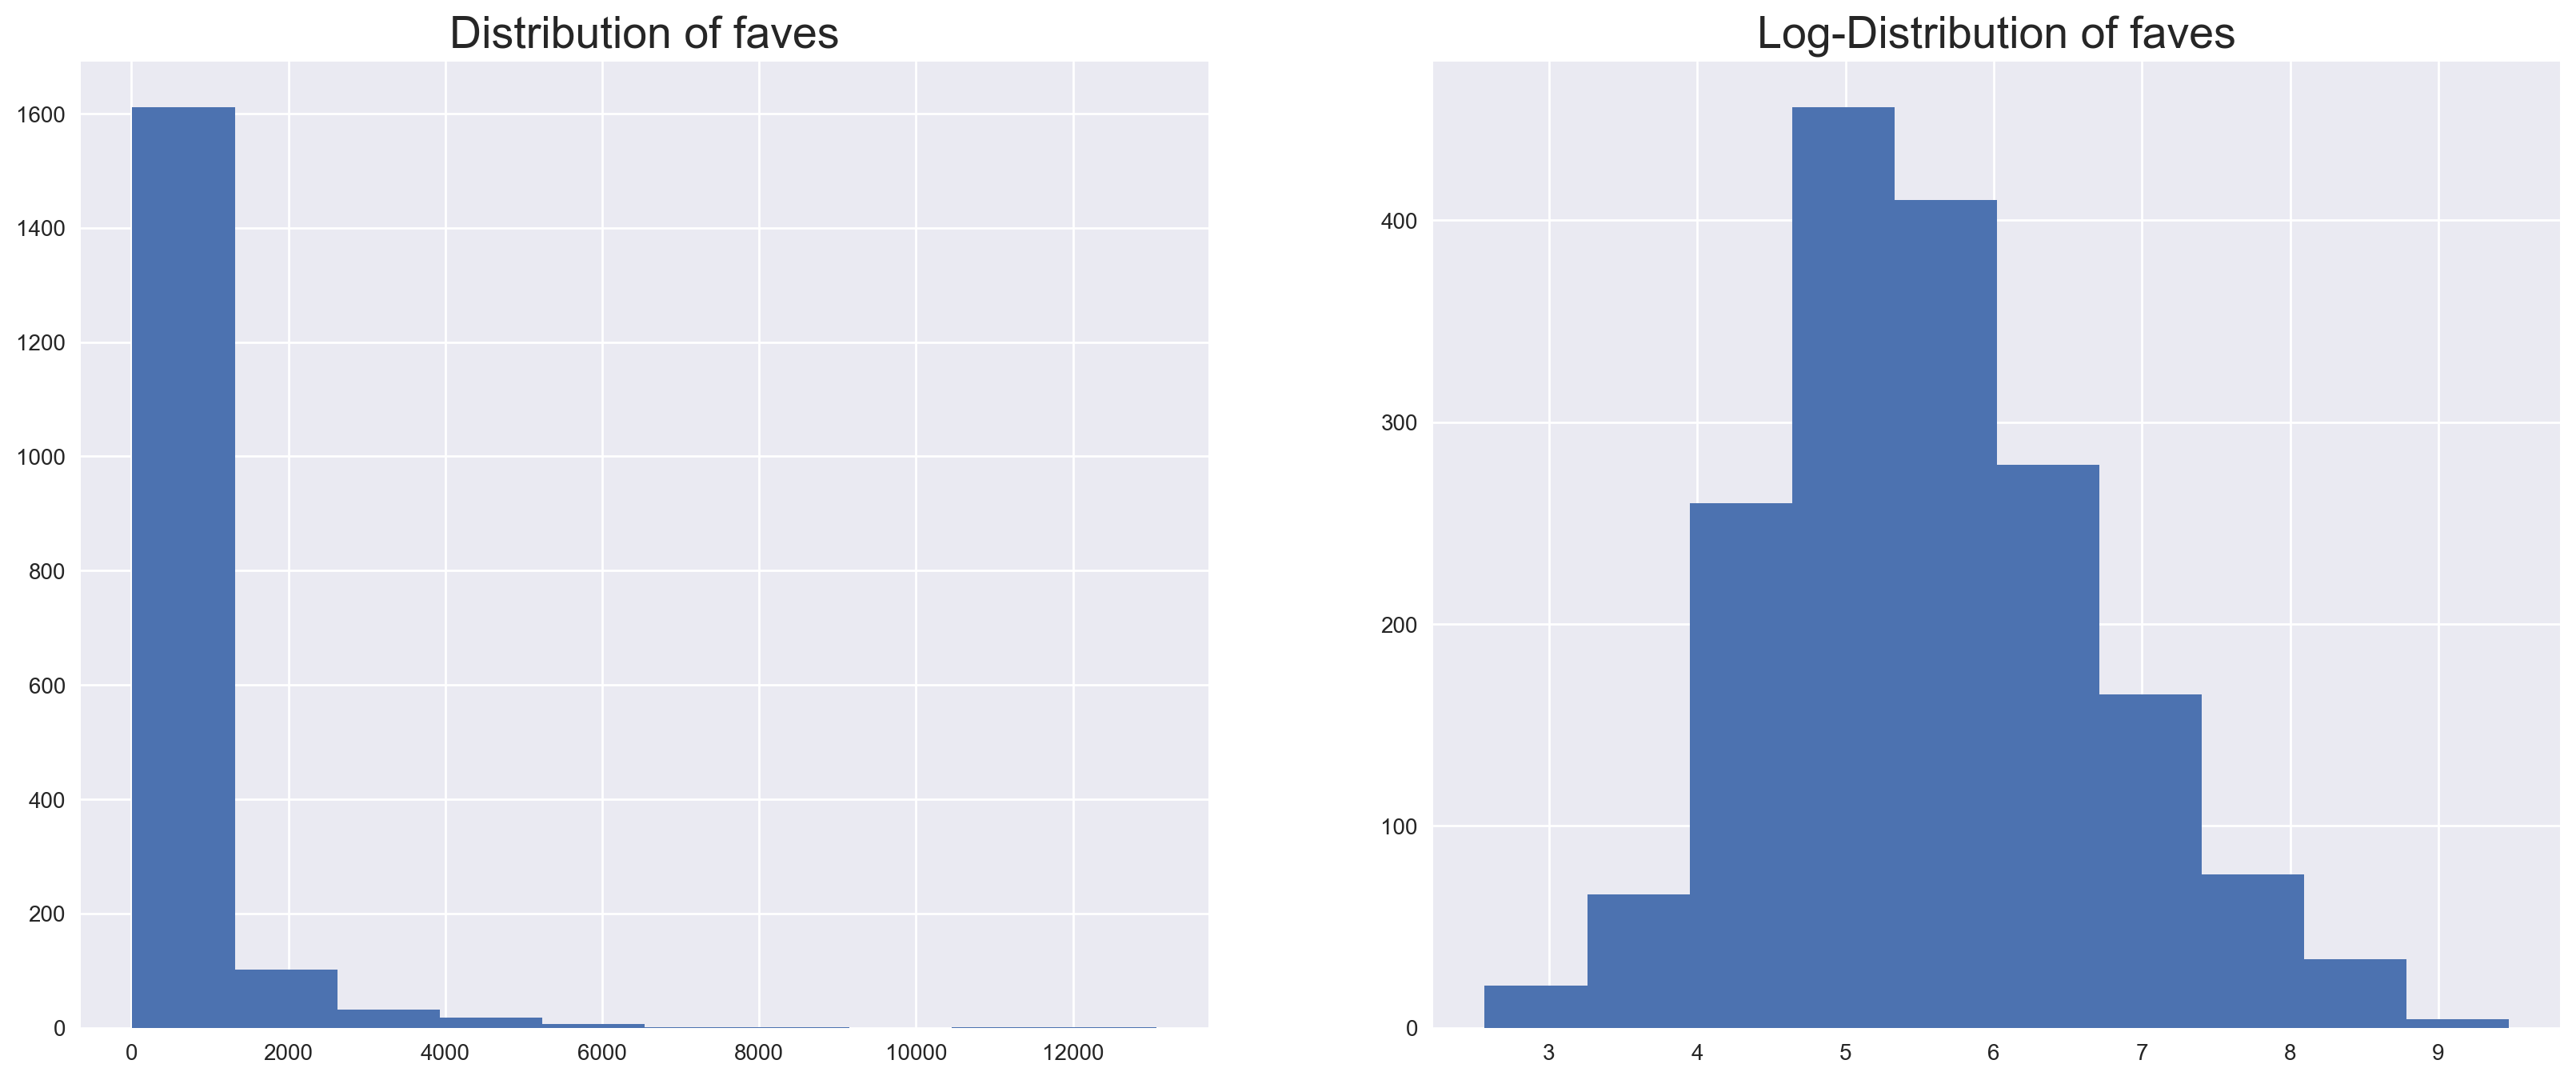

In [48]:
log_faves = np.log(df['faves'] + 1)

plt.figure(figsize=(20,8), dpi=200)
plt.subplot(1,2,1)
plt.title("Distribution of faves", size=20)
plt.hist(df['faves'])
plt.subplot(1,2,2)
plt.title("Log-Distribution of faves", size=20)
plt.hist(log_faves)

Since a power law is observed in the distribution of faves, they are normalized by creating a log distribution of faves. The log-distribution resembles a Gaussian, which should make the training process easier.



<h2>Building Models</h2>

In [61]:
#predicting popularity based on the number of comments
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

X = np.array(df['comments']).reshape(-1, 1)
y = np.array(df['faves']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear_reg = LinearRegression().fit(X_train, y_train)
ridge_reg = RidgeCV().fit(X_train, y_train)
elastic_reg = ElasticNetCV().fit(X_train, y_train.ravel())


In [62]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

def predict_score(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    expl_var = explained_variance_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    scores = [r2, expl_var, mae]
    
    return predictions, scores

lin_pred, lin_score = predict_score(linear_reg, X_test, y_test)
ridge_pred, ridge_score = predict_score(ridge_reg, X_test, y_test)
elastic_pred, elastic_score = predict_score(elastic_reg, X_test, y_test)


In [63]:
print(lin_score, ridge_score, elastic_score)

[0.30532173460119627, 0.31301642451301726, 314.896003180474] [0.3053228924784246, 0.31301757507991823, 314.8958865962948] [0.3650599920381056, 0.3723538692479743, 309.561869814841]


<h2>CNN time</h2>

In [5]:
from skimage.transform import resize
import matplotlib.image as mpimg

#create empty image lists
image_resized_lst = []
image_original_lst = []

#height and width of resized image
new_height = 250
new_width = 250


#image loading has to be done one-by-one to ensure that the images are loaded in the corresponding order to the
#data collected in the dataframe
for i in range(len(df)):
    my_dir = 'DA-images/'
    img_path = df['image_paths'][i][0]
    #load image
    img = mpimg.imread(my_dir + img_path)
    image_original_lst.append(img)
    #resize image
    img_resized = resize(img,(new_height,new_width),
                        mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    image_resized_lst.append(img_resized)
    
original_arr = np.array(image_original_lst)
resized_arr = np.array(image_resized_lst)

In [6]:
print(f"Original images array shape: {original_arr.shape}\nResized images array shape: {resized_arr.shape}")

Original images array shape: (1771,)
Resized images array shape: (1771, 250, 250, 3)


Text(0,0.5,'Images Resized')

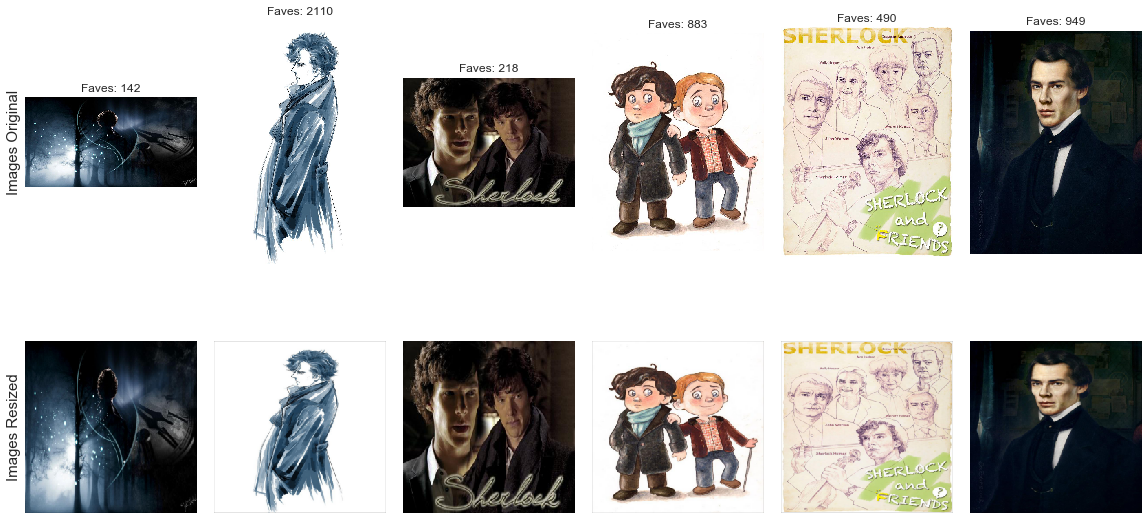

In [7]:
#peak at the resized images vs original images
fig, ax = plt.subplots(2, 6, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(6):
    ax[0, i].imshow(original_arr[i])
    ax[1, i].imshow(resized_arr[i])
    ax[0, i].set_title(f"Faves: {df.faves[i]}")
    
ax[0, 0].set_ylabel('Images Original',size=15)
ax[1, 0].set_ylabel('Images Resized',size=15)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = (250,250,3)

def baseline_model():
    # create model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
# build regression estimator
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=20, verbose=1, validation_split=0.2)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = resized_arr
y = np.array(log_faves)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1416, 250, 250, 3) (355, 250, 250, 3) (1416,) (355,)


In [40]:
estimator.fit(X_train, y_train)

Train on 1132 samples, validate on 284 samples
Epoch 1/10
1132/1132 [==============================] - 136s 121ms/step - loss: 34.8388 - val_loss: 5.4888
Epoch 2/10
1132/1132 [==============================] - 130s 115ms/step - loss: 4.3870 - val_loss: 2.0438
Epoch 3/10
1132/1132 [==============================] - 128s 113ms/step - loss: 2.5759 - val_loss: 2.8145
Epoch 4/10
1132/1132 [==============================] - 124s 109ms/step - loss: 2.6751 - val_loss: 1.7193
Epoch 5/10
1132/1132 [==============================] - 123s 108ms/step - loss: 1.7383 - val_loss: 1.5123
Epoch 6/10
1132/1132 [==============================] - 121s 107ms/step - loss: 1.3677 - val_loss: 1.3229
Epoch 7/10
1132/1132 [==============================] - 121s 107ms/step - loss: 1.3497 - val_loss: 1.2891
Epoch 8/10
1132/1132 [==============================] - 130s 115ms/step - loss: 1.0419 - val_loss: 2.0148
Epoch 9/10
1132/1132 [==============================] - 138s 122ms/step - loss: 1.2357 - val_loss: 2.113

1416/1416 [==============================] - 58s 41ms/step
Explained variance score: 0.19882023044722563
Mean absolute error: 324.566302587757


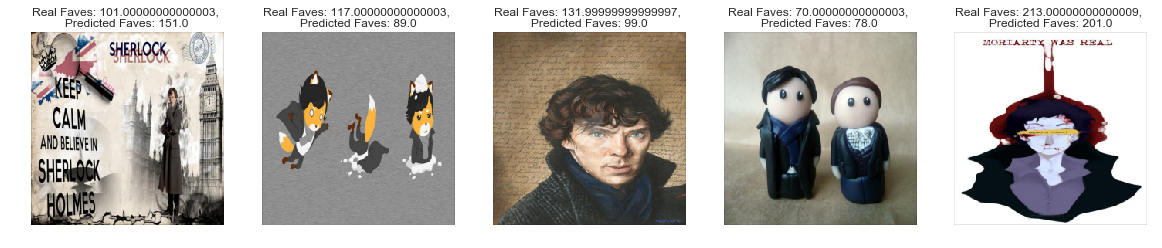

In [44]:
y_train = np.exp(y_train)
prediction = estimator.predict(X_train)
prediction = np.exp(prediction)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_train[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_train[i])
    
print(f"Explained variance score: {explained_variance_score(y_train, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_train, prediction)}")

355/355 [==============================] - 13s 35ms/step
Explained variance score: -0.013451777442125668
Mean absolute error: 519.4979183304478


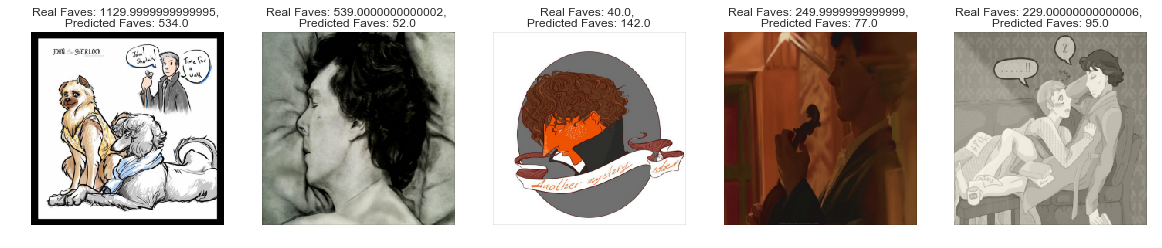

In [45]:


prediction = estimator.predict(X_test)
prediction = np.exp(prediction)
y_test = np.exp(y_test)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_test[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_test[i])
    
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_test, prediction)}")

Ideas to improve the model:
- only select pics of a certain dimension? e.g. filter out pics that are too long or too tall.